## Anomal Detection - Guilherme Albertini

- Results of about 6 Hr Effort Max
- Results found in this notebook
- Attach README

### Preprocessing/EDA

Data has been cleaned by previous author's last commit. No NAN values or dubious data types found.


In [812]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from matplotlib.cbook import boxplot_stats
import seaborn as sns
from sklearn.cluster import KMeans


dateCols = ['timestamp']
df = pd.read_csv('data/ambient_temperature_system_failure.csv',
                 sep=',', parse_dates=dateCols)
df.rename(columns={'value': 'temp_F'}, inplace=True)
df.timestamp = pd.to_datetime(df.timestamp)
print('Number of NAN per column: ')
print(df.isna().sum())
print(df.dtypes)
df.head()


Number of NAN per column: 
timestamp    0
temp_F       0
dtype: int64
timestamp    datetime64[ns]
temp_F              float64
dtype: object


,timestamp,temp_F
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


For a better visualization, I will split up the time series data into seasonal representations. We first must set the date ranges of the seasons below.


In [813]:
# Dates span 2013-07-04 to 2014-05-28

# Summer (June|->July 2013 - August 2013)
start_date = pd.to_datetime('7/1/2013 00:00:00')
end_date = pd.to_datetime('8/31/2013 00:00:00')
summer = df.loc[(df['timestamp'] > start_date) & (df['timestamp'] < end_date)]
summer_temps = summer['temp_F']

# Fall (September 2013 - November 2013)
start_date = pd.to_datetime('9/1/2013 00:00:00')
end_date = pd.to_datetime('11/30/2013 00:00:00')
fall = df.loc[(df['timestamp'] > start_date) & (df['timestamp'] < end_date)]
fall_temps = fall['temp_F']

# Winter (December 2013 - February 2014)
start_date = pd.to_datetime('12/1/2013 00:00:00')
end_date = pd.to_datetime('2/28/2014 00:00:00')
winter = df.loc[(df['timestamp'] > start_date) & (df['timestamp'] < end_date)]
winter_temps = winter['temp_F']

# Spring (March 2014 - May 2014)
start_date = pd.to_datetime('3/1/2014 00:00:00')
end_date = pd.to_datetime('5/31/2014 00:00:00')
spring = df.loc[(df['timestamp'] > start_date) & (df['timestamp'] < end_date)]
spring_temps = spring['temp_F']

min_temp = min(summer_temps.min(), fall_temps.min(),
               winter_temps.min(), spring_temps.min())
min_temp = math.floor(min_temp - 2.0)
max_temp = max(summer_temps.max(), fall_temps.max(),
               winter_temps.max(), spring_temps.max())
max_temp = math.ceil(max_temp + 2.0)

print("Min:", min_temp, "Max:", max_temp)


Min: 55 Max: 89


Text(0.5, 1.0, 'Spring Office Temperature')

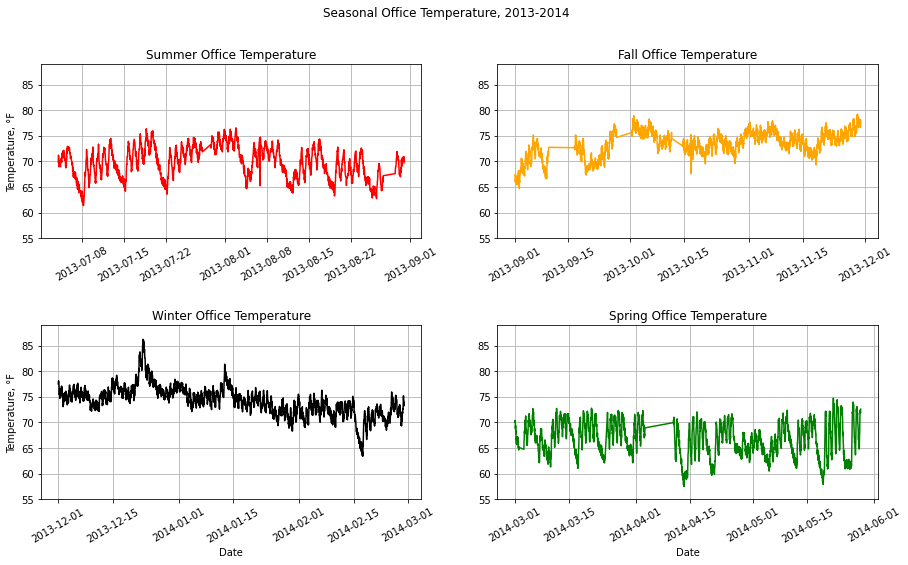

In [814]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

# Set line width
L = 1.0

# Plot
axes[0, 0].plot(summer['timestamp'], summer_temps, c='red')
axes[0, 1].plot(fall['timestamp'], fall_temps, c='orange')
axes[1, 0].plot(winter['timestamp'], winter_temps, c='black')
axes[1, 1].plot(spring['timestamp'], spring_temps, c='green')

fig.suptitle('Seasonal Office Temperature, 2013-2014')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=30)
    plt.grid()
    ax.set_ylim([min_temp, max_temp])

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.2)

axes[1, 0].set_xlabel('Date')
axes[1, 1].set_xlabel('Date')
axes[0, 0].set_ylabel('Temperature, °F')
axes[1, 0].set_ylabel('Temperature, °F')

axes[0, 0].set_title('Summer Office Temperature')
axes[0, 1].set_title('Fall Office Temperature')
axes[1, 0].set_title('Winter Office Temperature')
axes[1, 1].set_title('Spring Office Temperature')


We immediately notice there are linear segments in the data. I assume that these were dates where ambient office temperature readings were not taken, or the system was down, or office was shut down, etc. The authors chose to use linear interpolation for these gaps. It is also important to note that weather patterns in the region along with the seasons can account for macro trends in the data. It is also noted that there seems to be a cyclical nature to how the AC (?) works that can have latent effects on readings: if the building turns on the AC to some temperature and runs for some time t, the temperature readings will start to deviate from this value when the AC powers off after some time t + dt. When the sensor hits the desired temp it may (possibly) shut off and then back on again if too low or high an ambient temperature is recorded. This effect, combined with the desired temperatures set during work hours and off hours help explain this pattern we see above.

Some initial observations on the plots:

- Winter
  - Spike in office temperatures during 12/2013 and 1/2014 that may be anomolous
- Spring
  - Significant interpolation used during 4/2014 that could be flagged as an anomaly
  - A lot of separation between peaks and troughs of 4/2014 adn 5/2014 that can be flagged as anomalous altogether
- Summer
  - Ostensibly a more regular cyclical pattern
  - More significant interpolation used towards end of readings (9/2013) and in 7/2013 that may be flagged altogether
- Fall
  - Significant interpolation during 9/2013 that may be flagged as anomaly
  - Most stable cycle patterns?


> > https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

"We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation." Due to time constraints and my currently limited time series expertise, no further investigation into finding periodic signals obscured by noise is studied here.

> > https://towardsdatascience.com/detecting-stationarity-in-time-series-data-d29e0a21e638

I also do not use parametric or non-parametric tests to quantify the (almost certain) non-stationary nature of this seasonal data (that is, where its mean and deviations change over time), and apply transformations as plausible explanations are discussed above...and I would need twice the amount of time for this work...scope creep...

Instead I chose to plot rolling averages and standard deviations in upsampled (30 min) data to show that we indeed notice varying standard deviations and averages over time.


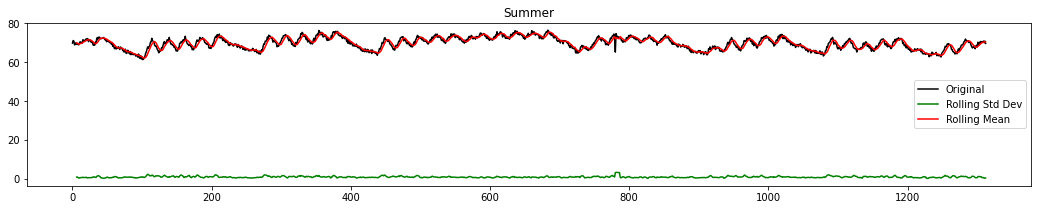

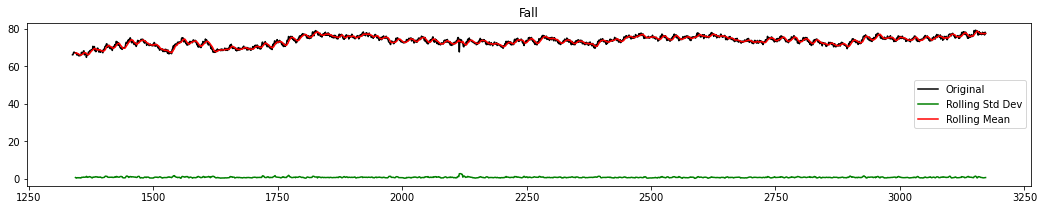

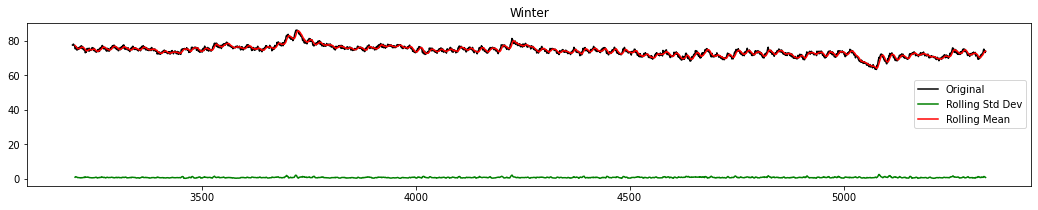

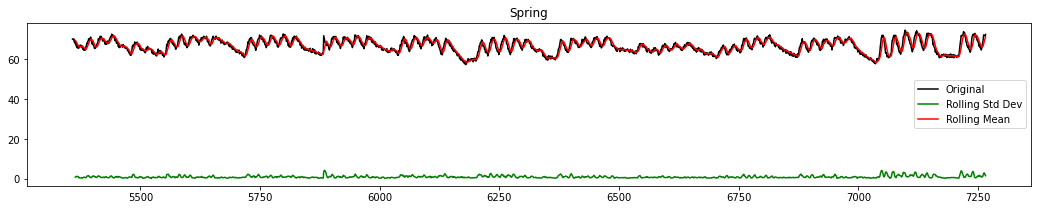

In [815]:
seasons = {'Summer': summer, 'Fall': fall, 'Winter': winter, 'Spring': spring}

# Plot time series for the seasons and observe the seasonality (non-stationary data)
for name, season in seasons.items():
    plt.figure(figsize=(18, 3))
    data = season.set_index('timestamp').resample(rule='30min').pad()
    roll_std = season['temp_F'].rolling(7).std()
    roll_avg = season['temp_F'].rolling(7).mean()
    plt.plot(season['temp_F'], color='black', label='Original')
    plt.plot(roll_std, color='green', label='Rolling Std Dev')
    plt.plot(roll_avg, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title(name)
    plt.show()


It is dubious that all temperature readings follow a normal distribution in the aggregate and also when examined at a more granular (seasonal level). Thus, we note that the MinMaxScaler should be opted for over StandardScaler should we normalize the numerical features. Should we have had more time, we could've looked at the parametric CDF of the Gaussian or of other distributions and compare them to the empirical CDF of these sets of temperatures.

> > https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler


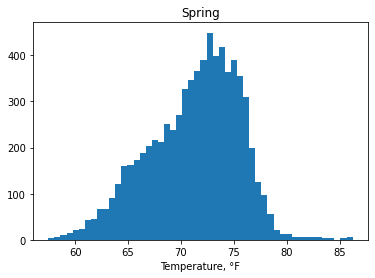

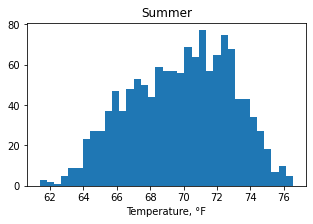

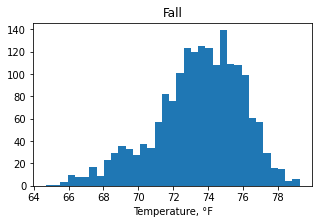

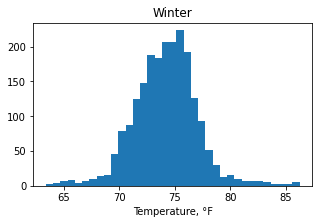

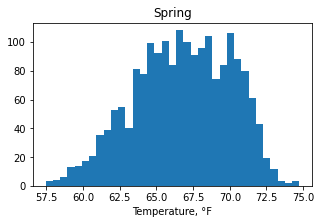

In [816]:
plt.hist(df['temp_F'], bins=50)
plt.title(name)
plt.xlabel('Temperature, °F')
plt.show()


for name, season in seasons.items():
    plt.figure(figsize=(5, 3))
    plt.hist(season['temp_F'], bins=35)
    plt.title(name)
    plt.xlabel('Temperature, °F')
    plt.show()


### Feature Engineering

We include the rolling average and standard deviation as additional features to consider in the time series temperature data. We also include the first and second finite difference derivatives as relevant numerical features to expand our playground. I also extract the Month and Time from the timestamp to later One-Hot encode them using the ML methods to follow instead of dealing with an unnecessarily sparse matrix resulting from encoding timestamp values.

To be clear, the derivatives mentioned above use finite differences. The second derivative is computed from Taylor expansions on a 3-point stencil $(i-1,i,i+1)$: $$\left(\frac{\partial^2 T}{\partial t^2}\right)_{i}  = \frac{1}{t^2}(T_{i-1}-2T_i+T_{i+1})$$

where I take the average of the first finite difference df['dT'] as $t$.


In [817]:

# https://math.stackexchange.com/questions/2391727/finite-difference-second-derivative-error-analysis

# Note that if rolling(N) then the first N-1 rows of results column will be NAN as we start averaging on the Nth entry
df['avg_roll'] = df['temp_F'].rolling(7).mean()
df['std_roll'] = df['temp_F'].rolling(7).std()
df['dT'] = df['temp_F'].diff()
delta = df['dT'].mean()

T = df['temp_F'].values
temp = []

for t in range(len(T)):
    try:
        res = (T[t+1]-2*T[t]+T[t-1])/delta**2
        temp.append(res)
    except IndexError:
        temp.append(np.nan)
        print('Out of bounds error handled by null assignment; note first 7 rows will be dropped alongside last row.')
        break
df['dT2'] = temp

df['Month'] = df['timestamp'].dt.month_name()

# https://stackoverflow.com/questions/44124436/python-datetime-to-season
# [month%12 // 3 + 1 for month in range(1, 13)]
df['Season'] = df['timestamp'].dt.month % 12 // 3 + 1
df['Season'] = df['Season'].replace(
    to_replace=[1, 2, 3, 4],
    value=['Winter', 'Spring', 'Summer', 'Fall'])

df['Time'] = df['timestamp'].dt.time

columns = ["temp_F", "avg_roll", "std_roll",
           "dT", "dT2", "Month", "Season", "Time"]

df = df.dropna()
df = df.reset_index(drop=True)
timestamp = df['timestamp']
# would otherwise remove timestamps as a column and do 0 to n, so saved above
df = df.reindex(columns=columns)
print(df.isna().sum().sum())
df.head()


Out of bounds error handled by null assignment; note first 7 rows will be dropped alongside last row.
0


,temp_F,avg_roll,std_roll,dT,dT2,Month,Season,Time
0,69.279765,69.937507,0.852932,-0.781201,6.292999e+06,July,Summer,06:00:00
1,69.369608,69.864475,0.880049,0.089844,-2.114933e+06,July,Summer,07:00:00
2,69.166714,69.571116,0.669989,-0.202895,1.608436e+05,July,Summer,08:00:00
3,68.986083,69.300870,0.368987,-0.180631,8.377793e+06,July,Summer,09:00:00
4,69.965062,69.444536,0.407631,0.978980,-2.802064e+06,July,Summer,10:00:00


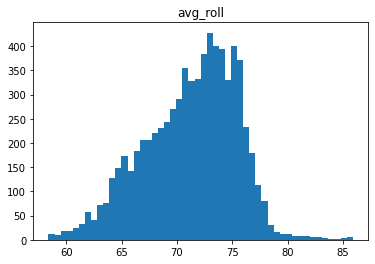

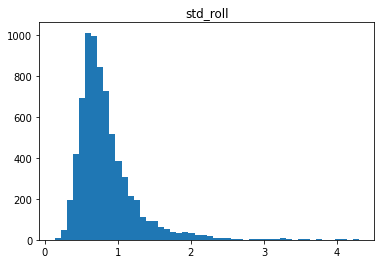

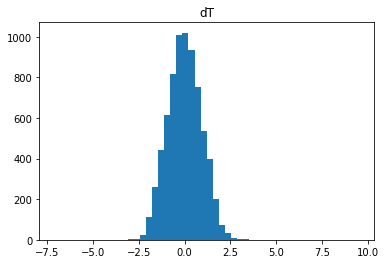

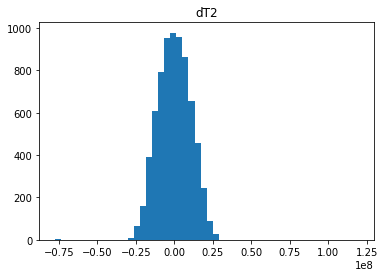

In [818]:
for feature in ['avg_roll','std_roll','dT','dT2']:
    plt.hist(df[feature], bins=50)
    plt.title(feature)
    plt.show()
# Gaussian-ish features should be ok to use for stats models relying on below...

### Anomaly Detection - Statistical Model: Boxplot (Baseline)

With time constraints in mind, I opt for a box plot using Seaborn library as our baseline statistical model for anomaly detection. It identified 1042 outliers based on the IQR outlier bounds. Note that, due to varying standard deviations, I reduce to +/-0.5 std deviations beyond the Q1 and Q3 quartiles for a more conservative approach.

NOTE: I do doubt this finding above due to both the non-stationary nature of the data and the interpolation segments observed throughout the data. In other lives, I would've upsampled the data being used here instead of using the interpolated baseline ("the plot with the weird linear segments") but I claim this was intentional to preserve the purity of the data...A correction factor may have to be applied later down the line to adequately identify outliers as the data was not transformed with the above concerns in mind.


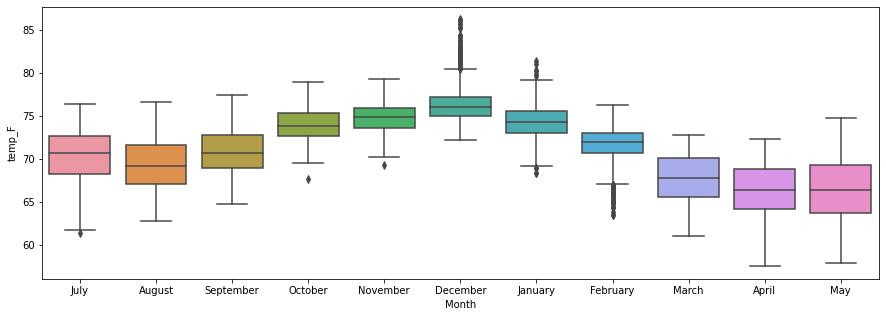

       temp_F   avg_roll  std_roll        dT           dT2 Month  Season  \
68  65.316423  66.639844  0.870453 -0.652164  5.525914e+06  July  Summer   
71  64.683917  65.941157  0.865585 -2.067067  1.407621e+07  July  Summer   
72  64.565207  65.569990  0.809370 -0.118710  1.216026e+07  July  Summer   
75  64.974812  65.518548  0.830167 -1.121318  3.477196e+06  July  Summer   
76  64.334790  65.362214  0.944923 -0.640023  1.334147e+07  July  Summer   

        Time  
68  02:00:00  
71  05:00:00  
72  06:00:00  
75  09:00:00  
76  10:00:00  
1042


In [819]:
fig, ax = plt.subplots()
fig.set_size_inches((15, 5))
sns.boxplot(x='Month', y='temp_F', data=df, ax=ax)
plt.show()

# https://stackoverflow.com/questions/53735603/extract-outliers-from-seaborn-boxplot
outliers = [y for stat in boxplot_stats(df['temp_F'], whis=0.5) for y in stat['fliers']]

# This will be our baseline anomaly model
# Curiously, the anomaly count did not change when dividing up by seasons instead of months.
baseline_outliers = df.loc[df['temp_F'].isin(outliers)]
print(baseline_outliers.head())
print(len(baseline_outliers))

### Aside: A Purist's Approach (Univariate Gaussian )

Alternatively, we couldv've used a univariate Gaussian (with the mean and covariance matrix parameter) and observed how the probabilities interact with our threshold $\epsilon$. Note that in a training set, $x^{(i)} \in \R^{n}$:

1. Fit model $p(x)$ using features that are Gaussian-ish (hopefully) and indicative of anomalous features:
\begin{aligned}
& \mu_j = \frac{1}{N} \displaystyle\sum_{j=1} ^{N} x_j^{(i)} \\
& \sigma^2_j = \frac{1}{N} \displaystyle\sum_{j=1} ^{N} \left(x_j^{(i)} - \mu_j\right)^2
\end{aligned}

Note that we really mean that $p(x)$ is given by $$p(x) = \prod\limits_{j=1}^N p(x_j; \mu_j, \sigma_j^2)$$

2. The density function of a univariate normal (or Gaussian) distribution is given by:
$$ p(x; \mu, \sigma^2) = \frac{1}{(2\pi)^{\frac{1}{2}} \sigma}\exp\left(-\frac{1}{2\sigma^2} \left(x - \mu^2\right) \right)$$

3. Flag as anomaly iff:  $p(x) < \epsilon$

I opted against this approach as it would've probably made for more work seeing that I had doubts on the normal distribution assumption seeing that this data is non-stationary and probably autocorrelated and...foreign. Not to mention that cross validation would be needed to choose a nice threshold epsilon. 


In [820]:
categorical_feature_mask = df.dtypes == object
categorical_features = df.columns[categorical_feature_mask].tolist()
print(categorical_features)

numeric_feature_mask = df.dtypes != object
# Do not encode timestamp as it is set as index
numeric_features = df.columns[numeric_feature_mask].tolist()[1:]
print(numeric_features)

df.head()


['Month', 'Season', 'Time']
['avg_roll', 'std_roll', 'dT', 'dT2']


,temp_F,avg_roll,std_roll,dT,dT2,Month,Season,Time
0,69.279765,69.937507,0.852932,-0.781201,6.292999e+06,July,Summer,06:00:00
1,69.369608,69.864475,0.880049,0.089844,-2.114933e+06,July,Summer,07:00:00
2,69.166714,69.571116,0.669989,-0.202895,1.608436e+05,July,Summer,08:00:00
3,68.986083,69.300870,0.368987,-0.180631,8.377793e+06,July,Summer,09:00:00
4,69.965062,69.444536,0.407631,0.978980,-2.802064e+06,July,Summer,10:00:00


We encode categorical features using one-hot enconding and scale numerical features using the MinMaxScaler.


In [821]:
num = df[numeric_features].values  # returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(num)
normalized_df = pd.DataFrame(x_scaled)
df[numeric_features] = normalized_df
df = df.dropna()

for column in categorical_features:
    tempdf = pd.get_dummies(df[column], prefix=column)
    df = pd.merge(
        left=df,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df = df.drop(columns=column)

print(df.isna().sum().sum())
df.head()


0


,temp_F,avg_roll,std_roll,dT,dT2,Month_April,Month_August,Month_December,Month_February,Month_January,...,Time_14:00:00,Time_15:00:00,Time_16:00:00,Time_17:00:00,Time_18:00:00,Time_19:00:00,Time_20:00:00,Time_21:00:00,Time_22:00:00,Time_23:00:00
0,69.279765,0.419721,0.172201,0.380316,0.425389,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,69.369608,0.417066,0.178716,0.432806,0.382858,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,69.166714,0.406399,0.128250,0.415166,0.394370,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,68.986083,0.396573,0.055936,0.416507,0.435934,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,69.965062,0.401797,0.065220,0.486387,0.379382,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Anomaly Detection ML Model - KMeans Clustering

Due to time and knowledge constraints wrt this dataset I opted for a simple model for anomaly detection. I use the Elbow method to select the number of clusters. Perhaps unsurprisingly, 4 clusters are ideal, indicative of the cardinality of seasons.


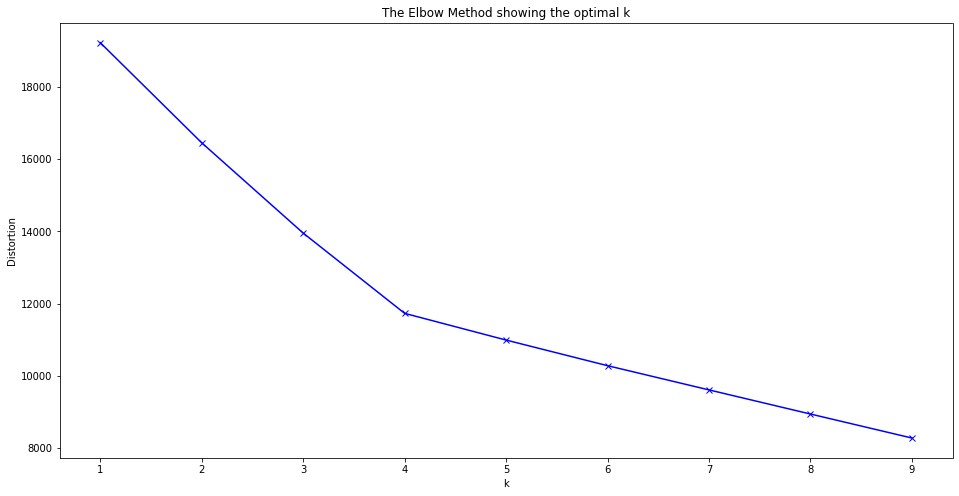

In [822]:
# Borrowed for time: https://predictivehacks.com/k-means-elbow-method-code-for-python/
x = df.drop(columns='temp_F')
y = df['temp_F']

distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(x)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


A threshold (see outliers_fraction) is artificially set for KMeans, using the approximate fraction of outliers we get from the baseline stats model as a guideline. In future work, this must be tuned using CV.

In [823]:
kmeans = KMeans(n_clusters=4, random_state=42)

# Distance between each point and its nearest centroid. The biggest distances are considered anomalous.
alldistances = pd.DataFrame(kmeans.fit_transform(x))
min_distance = alldistances.min(axis=1)
min_distance.name = 'MIN'


# Baked in linear trends due to interpolation and filling values of dataset distorting this fraction; 
# Note outliers came from baseline IQR model. Cross val used in future work for this...
outliers_fraction = 0.15
number_of_outliers = int(outliers_fraction*len(alldistances))
# Take the minimum of the largest fraction of the distances as the threshold
threshold = min_distance.nlargest(number_of_outliers).min()
# Anomaly-->0:ok, 1:lol
df['Anomaly'] = (min_distance >= threshold).astype(int)
df['timestamp'] = timestamp
df.head()

,temp_F,avg_roll,std_roll,dT,dT2,Month_April,Month_August,Month_December,Month_February,Month_January,...,Time_16:00:00,Time_17:00:00,Time_18:00:00,Time_19:00:00,Time_20:00:00,Time_21:00:00,Time_22:00:00,Time_23:00:00,Anomaly,timestamp
0,69.279765,0.419721,0.172201,0.380316,0.425389,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2013-07-04 06:00:00
1,69.369608,0.417066,0.178716,0.432806,0.382858,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2013-07-04 07:00:00
2,69.166714,0.406399,0.128250,0.415166,0.394370,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2013-07-04 08:00:00
3,68.986083,0.396573,0.055936,0.416507,0.435934,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2013-07-04 09:00:00
4,69.965062,0.401797,0.065220,0.486387,0.379382,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2013-07-04 10:00:00


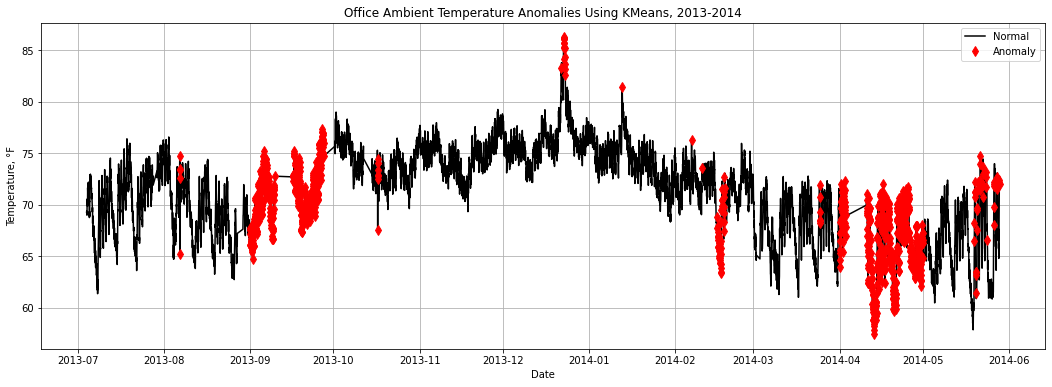

         temp_F           timestamp
774   65.260177 2013-08-06 20:00:00
775   74.762234 2013-08-06 21:00:00
776   73.495254 2013-08-06 22:00:00
777   73.365385 2013-08-06 23:00:00
778   72.597673 2013-08-07 00:00:00
...         ...                 ...
7234  72.680780 2014-05-27 13:00:00
7235  71.968614 2014-05-27 14:00:00
7256  72.370206 2014-05-28 11:00:00
7257  72.172956 2014-05-28 12:00:00
7258  72.046565 2014-05-28 13:00:00

[1089 rows x 2 columns]


In [824]:
oopsie = df[df['Anomaly'] == 1]
plt.figure(figsize=(18, 6))
plt.plot(df['timestamp'], df['temp_F'], color='black', label='Normal')
plt.plot(oopsie['timestamp'], oopsie['temp_F'], linestyle='none',
         marker='d', color='red', markersize=7, label='Anomaly')
plt.xlabel('Date')
plt.grid()
plt.ylabel('Temperature, °F')
plt.title('Office Ambient Temperature Anomalies Using KMeans, 2013-2014')
plt.legend(loc='best')
plt.show()
print(oopsie[['temp_F', 'timestamp']])

## Results and Findings

- The baseline boxplot method used custom IQR bounds (Q1-IQR/2 or Q3+IQR/2) to account for varying standard deviations when finding outliers. This was determined to be a more reasonable approach given the variance.
- The KMeans algorithm uses an artificial threshold which must be tuned but used the above as a guide
- The data has irregular linear trends due to interpolation and is non-stationary and probably autocorrelated. This should be invesitgated in future work.
- 9/2013 had a significant linear interpolation trend spotted during EDA. It is not surprising it has been flagged as a month of significant anomaly due to artifical data injection. The same can be said for 4/2014.
- Winter months of 2013 had significant peaks in data that have been flagged as anomalous -- specifically during the holiday period in late December. A holiday party or related end-of-year events may explain some of this irregular trend.

#### Model Results - Anomalous Office Temperature Readings

|      | Anomalies| Normal |
|------|----------|--------|
|KMeans|1089      |6171    |
|IQR   |1042      |6218    |
